In [1]:
import warnings
from string import ascii_uppercase

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
from IPython.display import HTML, display
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

sns.set()

## Context :

Every time a user browses an eligible web page, we have to decide whether to display an ad video or not.

If the video is displayed, then we will incur a fixed cost. However, we will benefit from a revenue only if the video is watched a minimum number of seconds by the user.

Thus, there are three possible cases:

- We do not display the video: Cost=0, Revenue=0, Profit=0
- We display a video that is not watched long enough: Cost>0, Revenue=0, Profit=-Cost
- We display a video that is watched long enough: Cost>0, Revenue>0, Profit=Revenue-Cost


## Log description :

the csv file is about 10000 examples of video ad displays. This log contains the following columns:
    
- creative_id: A unique identifier of the video that has been displayed to the user
- user_operating_system: The user Operating System (OS)
- user_device: The user device type
- average_seconds_played: The average number of seconds the user usually watches our videos (only if we already know the user, based on the user history)
- cost: The cost we had to pay to display the video
- revenue: The revenue generated by this video when it has been watched


## EDA : Exploratory Data Analysis :

In [2]:
data = pd.read_csv('aft100k.csv')

In [3]:
print('Information about the dataset (column names, number of non-null values, type of values) :')
data.info()

Information about the dataset (column names, number of non-null values, type of values) :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
creative_id               100000 non-null int64
user_operating_system     100000 non-null object
user_device               99992 non-null object
average_seconds_played    38172 non-null float64
cost                      100000 non-null float64
revenue                   100000 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.6+ MB


**Numerical features:**

In [4]:
print("Description for numerical features :")
data.describe()

Description for numerical features :


,creative_id,average_seconds_played,cost,revenue
count,100000.00000,38172.000000,100000.000000,100000.000000
mean,112156.27350,10.601625,0.005671,0.007789
std,5255.58913,9.791514,0.003503,0.014616
min,50634.00000,0.000000,0.000473,0.000000
25%,112190.00000,3.000000,0.003308,0.000000
50%,113521.00000,9.000000,0.004837,0.000000
75%,114948.00000,16.000000,0.006616,0.013416
max,115465.00000,175.000000,0.052878,0.145641


**Note :** creative_id should not be considered as numerical feature. In the rest of this document, I pay attention to this note.  

**Categorical features :**

In this dataset, we have to handle two categorical features which are : 
- user_operating_system
- user_device

In [5]:
print("List of uniques values taken by user_operating_system : ")
print(data.user_operating_system.unique())

List of uniques values taken by user_operating_system : 
['Android' 'Windows' 'iOS' 'macOS' 'OS X' 'Fire OS' 'Linux' 'Chrome OS'
 'BlackBerry OS' 'unknown' 'BSD' 'RIM OS']


In [6]:
print("List of uniques values taken by user_device : ")
print(data.user_device.unique())

List of uniques values taken by user_device : 
['Phone' 'PersonalComputer' 'Tablet' nan 'ConnectedTv']


**Preliminary observations :**

- For the feature "user_device" , we observe that there are few missing values. We can just delete the lines that correspond to them.
- For the feature average_seconds_played, there are a lot of missing values and we can't just delete them because it would be a huge loss of data. We would have to deal with this feature in another way.
- For categorical features, we will apply a get dummies. 
- For numerical features, I think that it is relevant to see how they are distributed and if it is relevant to apply transformations such as the log function.

### Insights from Creative_id feature:

In [7]:
number_of_videos = len(data.creative_id.unique())
print("There are", number_of_videos, "distinct videos in this dataset.")

There are 936 distinct videos in this dataset.


In [8]:
occ_videos = data[['cost', 'creative_id']].groupby(
    'creative_id').agg(['count'])
print('the average of diplayed videos is', int(round(occ_videos.mean())))
print('the median value of the occurence of video display is',
      int(round(occ_videos.median())))

the average of diplayed videos is 107
the median value of the occurence of video display is 30


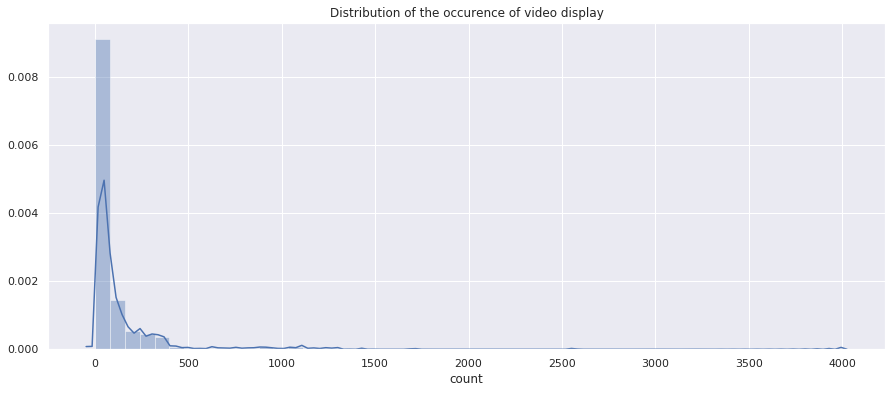

In [9]:
plt.figure(figsize=(15, 6))
sns.distplot(occ_videos['cost']['count'],
             label='Video display number', kde=True)
plt.title('Distribution of the occurence of video display')

It is relevant to examine the costs and revenues for each of the videos.

The distribution of the mean of revenue compared to the mean of cost per unique video : 


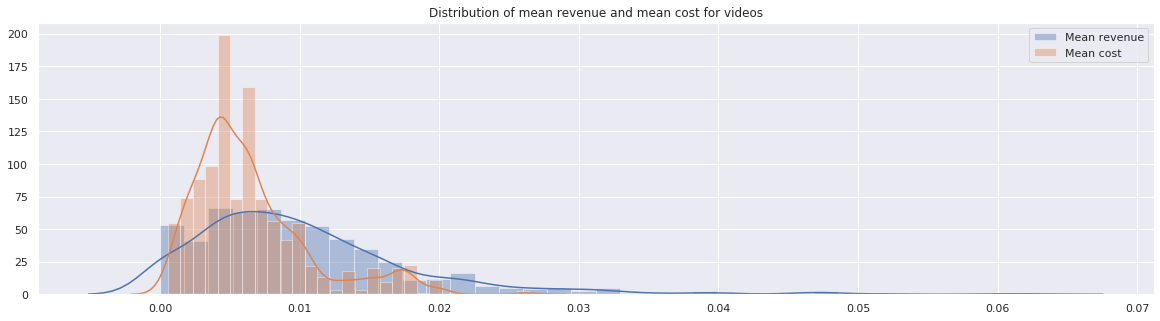

In [10]:
revenue_mean = data[['revenue', 'creative_id']
                    ].groupby('creative_id').agg(['mean'])
cost_mean = data[['cost', 'creative_id']].groupby('creative_id').agg(['mean'])
print('The distribution of the mean of revenue compared to the mean of cost per unique video : ')
fig, ax = plt.subplots(figsize=(20, 5))
sns.distplot(revenue_mean, ax=ax, label='Mean revenue')
sns.distplot(cost_mean, ax=ax, label='Mean cost')
plt.title('Distribution of mean revenue and mean cost for videos')
plt.legend()
plt.show();

We can see here with the overlapping lines of distributions that when the mean cost is greater than the mean revenue it means that these videos are not profitable. The profitable videos are those with mean cost lower than mean revenue.

In [11]:
number_of_profitable_videos = int(
    cost_mean[cost_mean['cost']['mean'] < revenue_mean['revenue']['mean']].count())
number_of_non_profitable_videos = int(
    cost_mean[cost_mean['cost']['mean'] > revenue_mean['revenue']['mean']].count())
print('There are', number_of_profitable_videos, 'profitable videos and',
      number_of_non_profitable_videos, 'non-profitable videos')

There are 616 profitable videos and 320 non-profitable videos


### Insights about categorical features : user_device and user_operating_system :

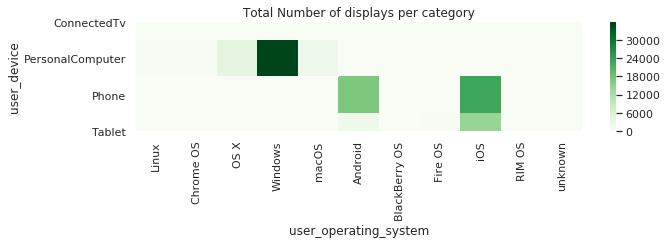

In [12]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.heatmap(data.groupby(['user_device', 'user_operating_system']).count()[
            'creative_id'].unstack(fill_value=0), cmap='Greens')
plt.title("Total Number of displays per category")
plt.show();

- We can see that the videos displayed on personal computers and precisely with the Windows OS are the most present in this dataset.
- we can also see that the videos are widely displayed on phones with iOS and android operating systems. 


### Insights about the Nan values in average_seconds_played feature:

In [13]:
number_of_missing_values = data['average_seconds_played'].isnull().sum()
print('The percentage of missing values is {}%'.format(
    number_of_missing_values*100/data.shape[0]))

The percentage of missing values is 61.828%


we note that 62% of users do not have a history of the time they have spent watching the videos.

Let's now try to see the distribution of the remaining 38% who correspond to people for whom we know the average time they spent watching videos.

The mean of average seconds played is 10.6s


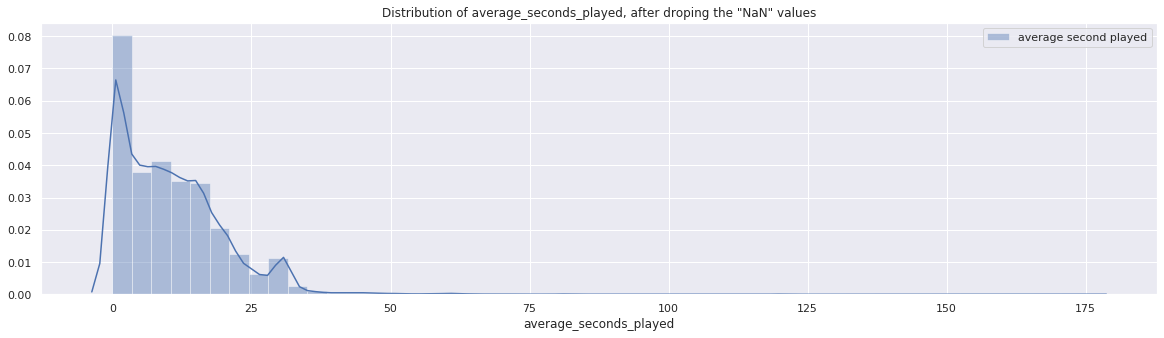

In [14]:
non_missing_average_second = data['average_seconds_played'].dropna()
print('The mean of average seconds played is {}s'.format(
    round(non_missing_average_second.mean(), 2)))
fig, ax = plt.subplots(figsize=(20, 5))
sns.distplot(non_missing_average_second, ax=ax, label='average second played')
plt.title('Distribution of average_seconds_played, after droping the "NaN" values')
plt.legend()

We can see from this distribution that many of the users which we have their history didn't see the videos (have seen it for 0s).

## Preliminary Questions

### Question 1 : The margin being defined as (revenue - cost) / revenue, what is our global margin based on this log?

In [15]:
print('The Global Margin Profit of this log file is {}%'.format(round(
    (data['revenue'].sum() - data['cost'].sum()) * 100 / data['revenue'].sum(), 2)))

The Global Margin Profit of this log file is 27.19%


### Question 2 : Can you think of other interesting metrics to optimize?

In addition to the marginal profit, there are many other interesting metrics that can be optimized:

- The first metric that we can think of is the net profit which is just the difference between the revenue and the cost. it gives us a clear idea about the profit and the efficiency of market stratagy.

$$ \text{Net profit} = Revenues - Costs $$ 

- Another metric that would be intresting to optimize is the market share for each os user which corresponds to the percentage of video displayed for each user OS category. We can also optimize by the same way the market share for each type of device. These metrices give us an idea about which of the devices and os categories are most profitable.

$$ \text{Market share per OS user} =100 \times \frac{\text {Number of videos displayed for a unique OS category}}{\text{ Total number of videos displayed}} $$

$$ \text{Market share per device} =100 \times \frac{\text{Number of videos displayed for a unique device}}{\text{ Total number of videos displayed}} $$

- Similarly to the gross profit margin, we can think of the return on advertising spend which is the amount of revenue a company receives for every dollar spent on an advertising source.
$$ \text{Return on advertising spend} =\frac{\text{Revenue from the ad}}{\text{Cost of the ad}} $$

- Another metric that can gives us an idea about the number of user who still watch the ad during a period is the customer retention rate (CRR) . it is the number of customers you still have at the end of a period relative to the number you had when that period started.
$$ \text{CRR} = 100 \times \frac{E-N}{S}  $$ 
    with :

    - E : the number of customers you have at the end of certain duration
    - N :  Number of new users to watch the videos acquired during the same time period
    - S : the number of users you had at the start of the period
    

### Question 3 : What are the most profitable Operating Systems?

To answer this question, I would start by looking at the gross profit margin.

In [16]:
cost_per_os = data[['cost', 'user_operating_system']].groupby(
    'user_operating_system').agg(['sum'])['cost']['sum']
revenue_per_os = data[['revenue', 'user_operating_system']].groupby(
    'user_operating_system').agg(['sum'])['revenue']['sum']

gross_profit_margin_per_os = (revenue_per_os-cost_per_os)/revenue_per_os

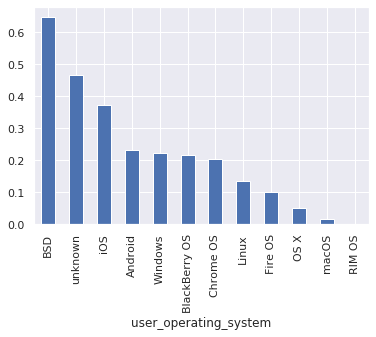

In [17]:
gross_profit_margin_per_os.sort_values(ascending=False).plot.bar();

From this graph we can see that, in terms of gross profit margin, BSD, IOS, Android and Windows are the most profitable systems.

this metric is not sufficient to conclude about the profitability of OS because it doesn't taken into account the volume or the market share of each device.

In [18]:
market_share_per_os = 100*data[['cost', 'user_operating_system']
                               ].groupby('user_operating_system').agg('count')/data['cost'].count()

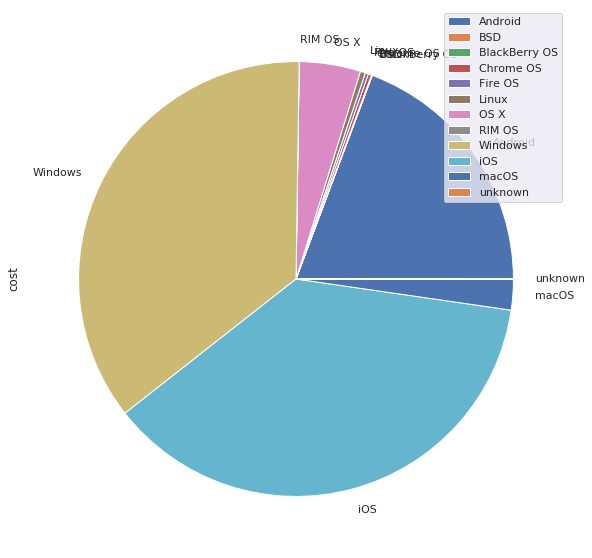

In [19]:
market_share_per_os.plot.pie(y='cost',figsize=(10,10))

We can see from this graph that the number of BSD users is really negligible compared to the number of users of the iOS, windows and Android. and therefore its contribution in terms of profit is minimal compared to the iOS, Windows and Android.

We can conclude that the most profitable operating systems are iOS, Windows and Android.

## Machine learning questions

### Question 1 : How would you use this historical data to predict the event 'we benefit from a revenue' (ie revenue > 0) in a dataset where the revenue is not known yet?

The probleme that we have to deal with here is a binary classification problem where the class *benefit_from_revenue = 1* represent the revenue>0 and *benefit_from_revenue = 0* is for the video with revenue = 0

To do this, we will create a new column that takes the benefit_from_revenue values from the revenue column and then, we have to remove the revenue column from the dataset to make our predictions.


In [20]:
data['benefit_from_revenue'] = np.where(data['revenue']>0,1,0)
data.head(20)

,creative_id,user_operating_system,user_device,average_seconds_played,cost,revenue,benefit_from_revenue
0,113521,Android,Phone,NaN,0.010128,0.000000,0
1,115340,Windows,PersonalComputer,0.000000,0.005937,0.000000,0
2,113582,Android,Phone,7.142857,0.004398,0.000000,0
3,97385,Windows,PersonalComputer,NaN,0.006157,0.000000,0
4,114821,Windows,PersonalComputer,NaN,0.001994,0.000000,0
5,113065,Android,Tablet,NaN,0.003781,0.000000,0
6,111414,iOS,Phone,17.000000,0.002836,0.000000,0
7,111414,iOS,Phone,NaN,0.002836,0.000000,0
8,112705,Windows,PersonalComputer,14.560606,0.006157,0.000000,0
9,113176,macOS,PersonalComputer,0.000000,0.006157,0.000000,0


### Question 2 : Compute the prediction accuracy of a well chosen algorithm and comment the results. Do not hesitate to describe your methodology.

The first thing to do is to split our data into train and validation set. The validation set will be used later to evaluate the performance of the model.

But before training the model, some preprocessing operations must be applied to the datasets:

- We need to deal with the problem of missing values in the column "average_seconds_played". we said previously that there is many missing values and we can't just remove them. We should try to replace them by an appropriate value.

- We should explore more the dataset in order to find relevant feature that we can add.

- We have to handle categorical data in order to feed it to the machine learning algorithm by using \textit{One hot encoder} 

- We need to check if our data is imbalanced.

- We need to standardize and scale the train set and the test set.

after that, at the model level, we have to:

- Choose the appropriate binary classification model

- Choose the metric to optimize

- Fine tune the hyperparameters of the model

#### Splitting dataset :

In [21]:
y = data['benefit_from_revenue']
X = data.drop(columns='benefit_from_revenue', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=0)

#### Dealing with the missing values for average_seconds_played column : 

To deal with the problem of missing value in the average_seconds_played column, we suggest, first, creating a new column category_average_seconds_played where we indicate the category of the average time spent on each video.

- Category "a" : to indicate the users that we don't have their average seconds played value.

- Category "b" : to indicate those who spent 0 second in watching the videos.

- Category "c" : for the users who spent between 0 and 10.6 seconds ( the mean value) in watching the video.

- Category "d" : for the people who spent more than 10.6 in watching the video.

Besides that, we can the NaN values in the column average_seconds_played by 0.


In [22]:
def fillna(data):
    data['category_average_seconds_played'] = data['average_seconds_played'].apply(lambda x: 'a' if (np.isnan(x))
                                                                                   else ('b' if x == 0 else ('c' if x > 0 and x <= 10.6 else 'd')))
    data['average_seconds_played'].fillna(0, inplace=True)
    return data

In [23]:
X_train = fillna(X_train)
X_test = fillna(X_test)

#### More features that we can add :

In addition, we can think about taking the mean average of cost and revenue for each video and also the mean average of seconds per video.

In [24]:
def add_features(data):
    av_rev_per_vid = data.groupby('creative_id').mean()['revenue'].reset_index(
    ).rename(columns={'revenue': 'average_revenue_per_vid'})
    av_cost_per_vid = data.groupby('creative_id').mean(
    )['cost'].reset_index().rename(columns={'cost': 'average_cost_per_vid'})
    av_sec_per_vid = data.groupby('creative_id').mean()['average_seconds_played'].reset_index(
    ).rename(columns={'average_seconds_played': 'average_seconds_played_per_vid'})

    data = data.merge(av_rev_per_vid, on='creative_id')
    data = data.merge(av_cost_per_vid, on='creative_id')
    data = data.merge(av_sec_per_vid, on='creative_id')
    return data

In [25]:
X_train = add_features(X_train)
X_test = add_features(X_test)

#### Dealing with categorical features :

Now after all the preprocessing and the added columns, we have three categrical features which are :

- user_operating_systems
- user_device
- category_average_seconds_played

In [26]:
def one_hot_encoding(data, y):
    data['label'] = y
    data.dropna(inplace=True)
    categorical_features = ['user_operating_system',
                            'user_device', 'category_average_seconds_played']
    data = pd.get_dummies(data=data, columns=categorical_features)
    data.drop(['revenue', 'creative_id'], axis=1, inplace=True)
    y = data.label
    return data.drop(columns=['label']), y

In [27]:
X_train, y_train = one_hot_encoding(X_train, y_train)
X_test, y_test = one_hot_encoding(X_test, y_test)

selected_columns = np.intersect1d(X_train.columns, X_test.columns)
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

#### Checking if our data is imbalanced : 

In [28]:
print('Percentage of benefit_from_revenue = 1 : {}%'.format(
    round((y_train.value_counts()[1]*100) / y_train.shape[0], 2), '%'))
print('Percentage of benefit_from_revenue = 0 : {}%'.format(
    round((y_train.value_counts()[0]*100) / y_train.shape[0], 2), '%'))

Percentage of benefit_from_revenue = 1 : 27.11%
Percentage of benefit_from_revenue = 0 : 72.89%


We can see here that the dataset we have is imbalanced. to handle this problem there is many ways to deal with the imbalanced data.
One of the most known ways is the resampling whether by oversampling or undersampling. 

- Oversampling consists of increasing the size of underrepresented data by applying bootstraping
- Undersampling consists of selecting randomly a sample of the over-represented class equal to the samples of the underrepresented class. 

In [29]:
def oversampling_bootstrapping(data, y_train):
    # Separate overrepresented and underrepresented classes
    data['label'] = y_train
    data_under = data[data.label == 1]
    data_over = data[data.label == 0]

    # oversample underrepresented class
    data_under_oversampled = resample(
        data_under,
        replace=True,
        n_samples=data_over.shape[0],
        random_state=0)

    data_oversampled = pd.concat([data_over, data_under_oversampled])
    y_oversampled = data_oversampled['label']
    return data_oversampled.drop(columns=['label']), y_oversampled

In [30]:
X_train,y_train = oversampling_bootstrapping(X_train,y_train)

#### Standardizing and scaling the data : 

In [31]:
stdscaler = StandardScaler()
X_train = stdscaler.fit_transform(X_train)
X_test = stdscaler.transform(X_test)

#### The choice of the model : 

For this task of binary classification, I will use the model **Xgboost**.I chose this model because it is usually better in accuracy among current algorithms like RandomForest , Decision Tree or Logistic regression. it runs efficiently on large datasets. also, with using regularization, it avoids the problem of overfitting. and it's really efficient for handling of missing data.

#### The choice of the metrics : 

The task that we are dealing with is binary classification. for this kind of problem we can use many metrics for the evaluation of the performance of our model:

 - As loss function, we can use the **log loss** which is appropriate to evaluate this kind of model.
 - Since our data is imbalanced, using the accuracy metric is not really appropriate.their are other metrics that can provide better insight and that we will use for this task. We can mention the **precision**, **the recall**, **the F1-score**, **the confusion matrix** and the **ROC curve**.

#### Tuning the hyperparameters of the model :

After choosing the appropriate model and the metric that we are going to rely on to evaluate the performance of our model, let's move to choose the best parameters that will allow our model to perform well.
There are many approaches to tune the hyperparameters of the model like Gridsearch, Randomsearch, or Bayesian search which are the most popular ones. For this task, I will take the most basic approach which is the **Gridsearch**.

In [32]:
# I will take the default parameters for this model!
clf_without_tuning = XGBClassifier()
clf_without_tuning.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [33]:
clf = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={'max_depth': (5, 10, 15),
                'n_estimators': (50, 100, 200),
                'learning_rate': (0.01, 0.1, 0.2)
                },
    scoring='f1',
    cv=5,
    n_jobs=3,
    verbose=1,
    refit=True)

In [34]:
result = clf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.8min
[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed: 17.0min finished


##### The precision , the recall and the f1-score : 

*For the model without tuning :*

In [35]:
y_true, y_pred_without_tuning = y_test, clf_without_tuning.predict(X_test)
print(classification_report(y_true, y_pred_without_tuning))

              precision    recall  f1-score   support

         0.0       0.72      0.49      0.58       729
         1.0       0.28      0.52      0.37       282

   micro avg       0.50      0.50      0.50      1011
   macro avg       0.50      0.50      0.47      1011
weighted avg       0.60      0.50      0.52      1011



*For the model with tuning of hyperparameters:*

In [36]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74       729
         1.0       0.30      0.28      0.29       282

   micro avg       0.62      0.62      0.62      1011
   macro avg       0.52      0.51      0.51      1011
weighted avg       0.61      0.62      0.61      1011



##### The confusion matrix : 

*For the model without tuning :*

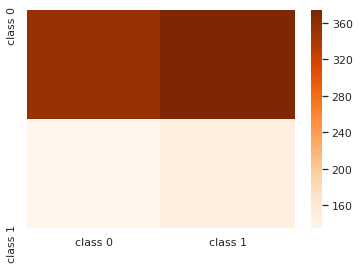

In [37]:
columns = ['class %s' % (i) for i in['0', '1']]

confm = confusion_matrix(y_test, y_pred_without_tuning)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges')

*For the model with tuning of hyperparameters:*

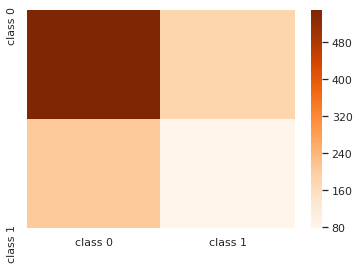

In [38]:
columns = ['class %s' % (i) for i in['0', '1']]

confm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(confm, index=columns, columns=columns)

ax = sns.heatmap(df_cm, cmap='Oranges')

##### The ROC curve : 

*For the model without tuning :*

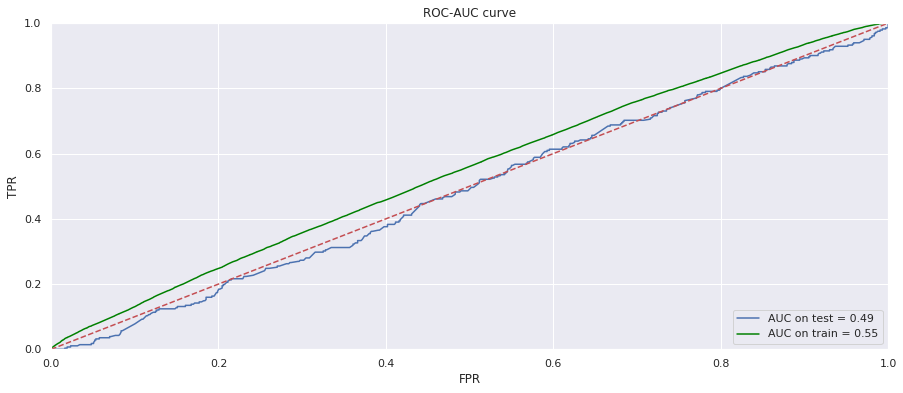

In [39]:
y_pred_proba_test_wt = clf_without_tuning.predict_proba(X_test)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_proba_test_wt[:, 1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

y_pred_proba_train_wt = clf_without_tuning.predict_proba(X_train)
fpr_train, tpr_train, _ = metrics.roc_curve(
    y_train, y_pred_proba_train_wt[:, 1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

plt.figure(figsize=(15, 6))
plt.title('ROC-AUC curve')
plt.plot(fpr_test, tpr_test, 'b', label='AUC on test = %0.2f' % roc_auc_test)
plt.plot(fpr_train, tpr_train, 'green',
         label='AUC on train = %0.2f' % roc_auc_train)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

*For the model with tuning of hyperparameters:*

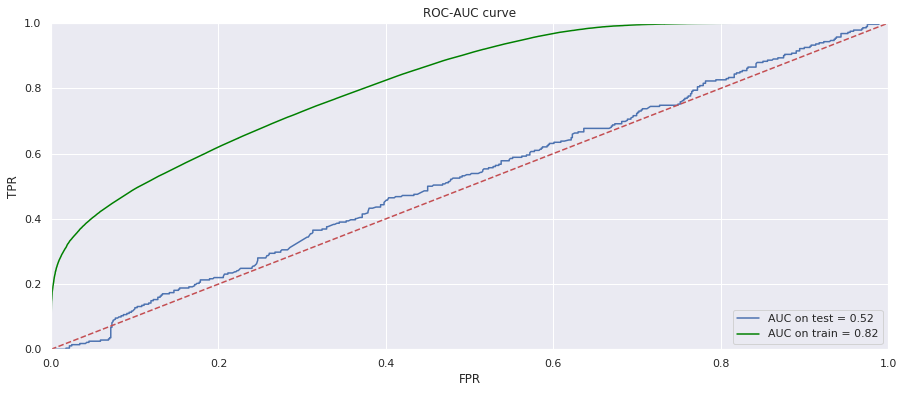

In [40]:
y_pred_proba_test = clf.predict_proba(X_test)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_pred_proba_test[:, 1])
roc_auc_test = metrics.auc(fpr_test, tpr_test)

y_pred_proba_train = clf.predict_proba(X_train)
fpr_train, tpr_train, _ = metrics.roc_curve(y_train, y_pred_proba_train[:, 1])
roc_auc_train = metrics.auc(fpr_train, tpr_train)

plt.figure(figsize=(15, 6))
plt.title('ROC-AUC curve')
plt.plot(fpr_test, tpr_test, 'b', label='AUC on test = %0.2f' % roc_auc_test)
plt.plot(fpr_train, tpr_train, 'green',
         label='AUC on train = %0.2f' % roc_auc_train)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

**Comments :**

Comparing the two models, before and after the tuning of hyperparameters, we can observe that : 

- We have a better AUC and f1-score for the training and the test set.
- The results in the confusion matrix seems to be better for the tuned model.
- In the confusion matrix, we can observe that the fine tuning of the hyperparameter allow us to have a model that minimize the number of false negatives.
- The f1-score, the precision and the recall was improved by fine tuning the hyperparameter of the model.


**What we can do to make our model better ?**

- Use a larger range of parameters in the fine tuning of the model. To do that it seems to be better to use the bayesian search instead of the Gridsearch because the gridseach take a lot of computation time and with a larger range, it wouldn't be convinient.

- Even though the Xgboost seems to have a good results, we can explore other kind of model especially Deep learning models.

- Try to find more feature that can improve the amount of generated revenue.